In [55]:
import requests
from dotenv import load_dotenv
import os 
import joblib
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
import matplotlib.pyplot as plt 

In [ ]:
rf_model = joblib.load( 'random_forest_fishing_model.pkl')

mpa_data = gpd.read_file(r"D:\Datasets\Illegal Fishing\Original Data\mpatlas_export_geo_202503_BhMDKpV\mpatlas_export_geo_202503\mpatlas_export_geo_202503\mpatlas_export_geo_202503\mpatlas_export_mar2025.gdb", 
                         layer='zoneassessment_geom').to_crs(epsg=4326)

gdb_path_ocean = rf'D:\Datasets\Illegal Fishing\Original Data\ne_110m_ocean\ne_110m_ocean.shp'
ocean_data = gpd.read_file(gdb_path_ocean)

gdb_path_land = rf'D:\Datasets\Illegal Fishing\Original Data\ne_10m_land\ne_10m_land.shp'
land_data = gpd.read_file(gdb_path_land)

load_dotenv()
token = os.getenv('token')


In [57]:

def api_request(start_date,end_date,limit):

    '''   
    Retrieves vessel event data from the Global Fishing Watch API.

    Parameters:
        start_date (str): Start date in 'YYYY-MM-DD' format.
        end_date (str): End date in 'YYYY-MM-DD' format.
        limit (int): Number of results to return (1–100).

    Returns:
        pd.DataFrame: A DataFrame containing vessel_id, speed, distance_from_shore (m),
                      distance_from_port (m), latitude, and longitude.
    
    
    '''

# API URL
    url = 'https://gateway.api.globalfishingwatch.org/v3/events'

    if not (1 <= limit <= 100):
        print("Please enter a value between 1 and 100.")
        return 

# Parameters for the GET request
    params = {
        'datasets[0]': 'public-global-fishing-events:latest',
        'start-date': start_date,
        'end-date': end_date,
        'limit': limit,
        'offset': 0
     }


# Define the headers, including the authorization token
    headers = {
        'Authorization': f'Bearer {token}'
        }

# Make the GET request
    response = requests.get(url, headers=headers, params=params)

# Check if the request was successful
    if response.status_code == 200:
    
    # Parse the JSON response
        data = response.json()

    #Extract relevant data 
        extracted_data =[]

        for i in range(limit):

            lat = data['entries'][i]['position'].get('lat')
            lon = data['entries'][i]['position'].get('lon')
            distance_from_shore = data['entries'][i]['distances'].get('startDistanceFromShoreKm')*1000
            distance_from_port = data['entries'][i]['distances'].get('startDistanceFromPortKm')*1000
            speed = data['entries'][i]['fishing'].get('averageSpeedKnots')
            id = data['entries'][i]['vessel'].get('id')

            extracted_data.append( [id,speed,distance_from_shore,distance_from_port,lat,lon]) 
       

    else:
        print(f"Failed to retrieve data: {response.status_code}")
        print(response.text)
    
    
    extracted_df = pd.DataFrame(extracted_data,columns=['vessel_id','speed','distance_from_shore','distance_from_port','lat','lon'])
    
    return extracted_df 
    


In [58]:
def predict_fishing_status(df):

    ''' 
    Predicts the fishing status of vessels using a pre-trained Random Forest model.

    Parameters:
        df (pd.DataFrame): A DataFrame containing the following columns:
            - vessel_id
            - speed
            - distance_from_shore (m)
            - distance_from_port (m)
            - lat
            - lon

    Returns:
        pd.DataFrame: The original DataFrame with two additional columns:
            - prediction (int): Model output (0 or 1).
            - status (str): 'Fishing' or 'Not Fishing' based on the prediction.

    Notes:
        - Assumes a pre-trained Random Forest model (`rf_model`) is loaded and accessible.
        - `vessel_id` is dropped before prediction and retained in the final output.
    
    '''


    model_input = df.drop('vessel_id',axis=1)
    model_input = model_input.values    

    rf_predictions = rf_model.predict(model_input)

# Add the predictions to the DataFrame
    df['prediction'] = rf_predictions
    df['status'] = df['prediction'].map({0: 'Not Fishing', 1: 'Fishing'})

    return df


In [59]:
def filter_through_mpz(df):
    ''' 
    Filters vessel positions to include only those in the ocean and labels them as illegal based on Marine Protected Zones (MPZ).

    Parameters:
        df (pd.DataFrame): DataFrame with columns ['vessel_id', 'speed', 'distance_from_shore', 
                                                   'distance_from_port', 'lat', 'lon', 
                                                   'prediction', 'status']

    Returns:
        gpd.GeoDataFrame: Filtered and labeled GeoDataFrame with an additional 'illegal' column.
    '''

    # Create GeoDataFrame
    geometry = [Point(lon, lat) for lon, lat in zip(df['lon'], df['lat'])]
    ship_gdf = gpd.GeoDataFrame(df, geometry=geometry, crs='EPSG:4326')  

    # Filter ships within ocean boundaries
    filtered_ships = gpd.sjoin(ship_gdf, ocean_data, how='inner', predicate='within')

    # Keep only desired columns
    keep_cols = ['vessel_id', 'speed', 'distance_from_shore', 'distance_from_port', 
                 'lat', 'lon', 'prediction', 'status', 'geometry']
    
    filtered_ships = filtered_ships.loc[:, keep_cols]

    # Find ships inside Marine Protected Areas
    intersections = gpd.sjoin(filtered_ships, mpa_data, how='inner', predicate='within')
    intersecting_indices = intersections.index.unique()

    # Assign 'illegal' status
    def assign_illegal_status(row):
        if row.name in intersecting_indices:
            return 'yes' if row['prediction'] == 1 else 'maybe'
        return 'no'

    filtered_ships['illegal'] = filtered_ships.apply(assign_illegal_status, axis=1)

    return filtered_ships



In [60]:
def plot(geo_df, point_size):
    ''' 
        Plots vessel positions overlaid on land and Marine Protected Areas (MPAs),
    with colors indicating suspected illegal fishing status.

    Parameters:
        geo_df (GeoDataFrame): A GeoDataFrame with columns including 'illegal', 
                               'geometry', and other vessel data.
        point_size (int or float): Size of the plotted vessel points.

    Returns:
        None. Displays a matplotlib plot.
    
    
    '''

    # Define custom colors
    color_map = {
    'yes': 'red',
    'maybe': 'orange',
    'no': 'green'
}

# Map colors to the GeoDataFrame
    geo_df['color'] = geo_df['illegal'].map(color_map)

# Plot
    fig, ax = plt.subplots(figsize=(14, 10))
    land_data.plot(ax=ax, color='lightgray', edgecolor='white', linewidth=0.5)
    mpa_data.plot(ax=ax, color='deepskyblue', alpha=0.6, edgecolor='black', linewidth=0.3)

# Plot each category separately for a custom legend
    for status, color in color_map.items():
        subset = geo_df[geo_df['illegal'] == status]
        if not subset.empty:
            subset.plot(ax=ax, markersize=point_size, color=color, label=status, alpha=0.8)

# Legend and title
    ax.legend(title='Illegal Fishing')
    ax.set_title("Illegal Fishing Activity in MPAs", fontsize=16)
    ax.set_axis_off()
    plt.tight_layout()
    plt.show()

In [61]:
data = api_request('2020-01-01','2020-02-01',5)

In [62]:
predictions = predict_fishing_status(data)
predictions

,vessel_id,speed,distance_from_shore,distance_from_port,lat,lon,prediction,status
0,ae3266034-4e76-81fa-49d6-41c212739db9,2.379821,95000,155930.031,-10.1118,140.9818,0,Not Fishing
1,e0806805d-d926-45c8-9f82-6b5f4e3cadf6,3.200947,7000,7725.455,28.9112,-95.2726,0,Not Fishing
2,e624f31d8-8a9e-5582-a4a7-049736112a1c,3.138300,9000,8721.766,27.8103,-96.9972,0,Not Fishing
3,d96c51da5-5132-d4c5-84a4-2dec87ab5629,2.592396,97000,164829.109,11.8492,-17.2521,0,Not Fishing
4,6873673ab-bebd-d9e0-75b5-0c3daf79a5da,0.163811,622000,379174.719,86.6480,115.8776,0,Not Fishing


In [63]:
filtered_data = filter_through_mpz(predictions)
filtered_data


,vessel_id,speed,distance_from_shore,distance_from_port,lat,lon,prediction,status,geometry,illegal
0,ae3266034-4e76-81fa-49d6-41c212739db9,2.379821,95000,155930.031,-10.1118,140.9818,0,Not Fishing,POINT (140.9818 -10.1118),no
1,e0806805d-d926-45c8-9f82-6b5f4e3cadf6,3.200947,7000,7725.455,28.9112,-95.2726,0,Not Fishing,POINT (-95.2726 28.9112),no
2,e624f31d8-8a9e-5582-a4a7-049736112a1c,3.138300,9000,8721.766,27.8103,-96.9972,0,Not Fishing,POINT (-96.9972 27.8103),no
3,d96c51da5-5132-d4c5-84a4-2dec87ab5629,2.592396,97000,164829.109,11.8492,-17.2521,0,Not Fishing,POINT (-17.2521 11.8492),no
4,6873673ab-bebd-d9e0-75b5-0c3daf79a5da,0.163811,622000,379174.719,86.6480,115.8776,0,Not Fishing,POINT (115.8776 86.648),no


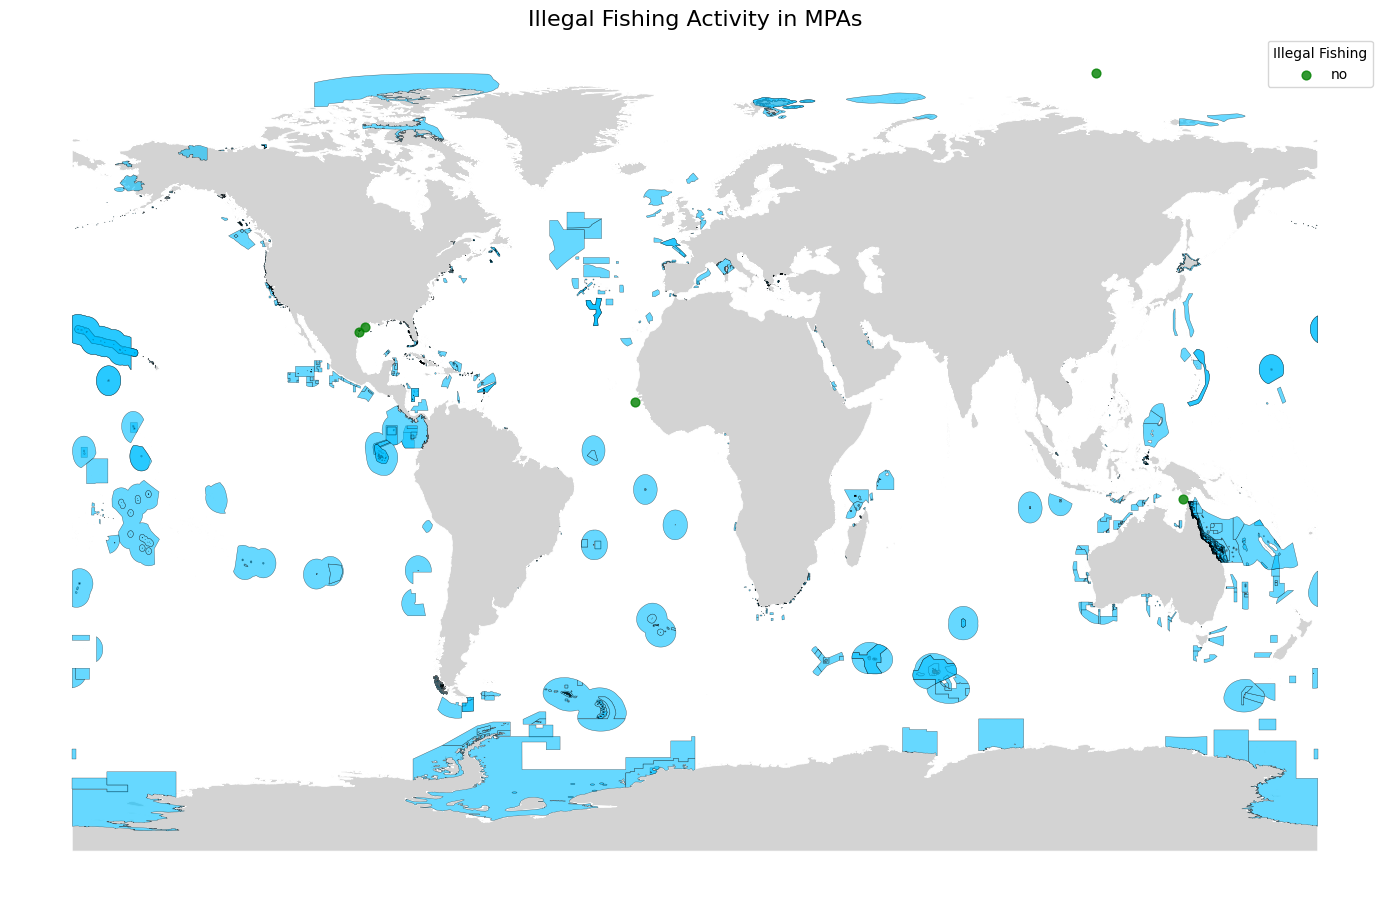

In [64]:
plot(filtered_data,40)